<a href="https://colab.research.google.com/github/eunicewly/GEOL0069_final/blob/main/GEOL0069_final_cloud_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Copernicus browser, Sentinel-3 OLCI (Ocean and Land Colour Instrument) data over Parque Nacional Amboró in Bolivia in the South American continent is downloaded for cloud classification. The data is then loaded and split into 5 image chunks. One of the chunk is then selected, from which 3 region of interests (roi) are obtained. Masks are created for each of the roi using IRIS (Intelligently Reinforced Image Segmentation), where image pixels are being classified as cloud and non-cloud, and they represent the "ground truth".

Machine learning models (Convolutional Neural Networks (CNN), Random Forest (RF) and Vision Transformer (ViT)) are then created, using one of the masks. The models are then applied to the 3 roi, and confusion matrices are calculated and created.

# **Loading in and converting downloaded data from Copernicus**

This involves loading in the downloaded Sentinel-3 OLCI data (in netCDF4 format), converting them into numpy arrays (.npy), and splitting them into 5 chunks such that it is possible for IRIS to display them in a single interface view.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install rasterio
! pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.2 MB/s eta 0:00:00


In [ ]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os
import netCDF4
import numpy as np
import re
from sklearn.feature_extraction import image

# Define the path to the main folder where your data is stored.
# You need to replace 'path/to/data' with the actual path to your data folder.
main_folder_path = '/content/drive/MyDrive/GEOL0069/final'
# main_folder_path = './'
# This part of the code is responsible for finding all directories in the main_folder that end with '.SEN3'.
# '.SEN3' is the format of the folder containing specific satellite data files (in this case, OLCI data files).
directories = [d for d in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, d)) and d.endswith('004.SEN3')] #load OLCI imagery

# Loop over each directory (i.e., each set of data) found above.
for directory in directories:
    # Construct the path to the OLCI data file within the directory.
    # This path is used to access the data files.
    OLCI_file_p = os.path.join(main_folder_path, directory)

    # Print the path to the current data file being processed.
    # This is helpful for tracking which file is being processed at any time.
    print(f"Processing: {OLCI_file_p}")

    # Load the instrument data from a file named 'instrument_data.nc' inside the directory.
    # This file contains various data about the instrument that captured the satellite data.
    instrument_data = netCDF4.Dataset(OLCI_file_p + '/instrument_data.nc')
    solar_flux = instrument_data.variables['solar_flux'][:]  # Extract the solar flux data.
    detector_index = instrument_data.variables['detector_index'][:]  # Extract the detector index.

    # Load tie geometries from a file named 'tie_geometries.nc'.
    # Tie geometries contain information about viewing angles, which are important for data analysis.
    tie_geometries = netCDF4.Dataset(OLCI_file_p + '/tie_geometries.nc')
    SZA = tie_geometries.variables['SZA'][:]  # Extract the Solar Zenith Angle (SZA).

    # Create a directory for saving the processed data using the original directory name.
    # This directory will be used to store output files.
    save_directory = os.path.join('/content/drive/MyDrive/GEOL0069/final/output', directory)
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # This loop processes each radiance band in the OLCI data.
    # OLCI instruments capture multiple bands, each representing different wavelengths.
    OLCI_data = []
    for Radiance in range(1, 22):  # There are 21 bands in OLCI data.

        Rstr = "%02d" % Radiance  # Formatting the band number.
        solar_flux_band = solar_flux[Radiance - 1]  # Get the solar flux for the current band.

        # Print information about the current band being processed.
        # This includes the band number and its corresponding solar flux.
        print(f"Processing Band: {Rstr}")
        print(f"Solar Flux for Band {Rstr}: {solar_flux_band}")

        # Load radiance values from the OLCI data file for the current band.
        OLCI_nc = netCDF4.Dataset(OLCI_file_p + '/Oa' + Rstr + '_radiance.nc')
        radiance_values = np.asarray(OLCI_nc['Oa' + Rstr + '_radiance'])

        # Initialize an array to store angle data, which will be calculated based on SZA.
        angle = np.zeros_like(radiance_values)
        for x in range(angle.shape[1]):
            angle[:, x] = SZA[:, int(x/64)]

        # Calculate the Top of Atmosphere Bidirectional Reflectance Factor (TOA BRF) for the current band.
        TOA_BRF = (np.pi * radiance_values) / (solar_flux_band[detector_index] * np.cos(np.radians(angle)))

        # Add the calculated TOA BRF data to the OLCI_data list.
        OLCI_data.append(TOA_BRF)

    reshaped_array = np.moveaxis(np.array(OLCI_data), 0, -1)
    OLCI_coord = netCDF4.Dataset(OLCI_file_p + '/geo_coordinates.nc')
    OLCI_lon=OLCI_coord['longitude']
    OLCI_lat=OLCI_coord['latitude']

    # Reshape the OLCI_data array for further analysis or visualization.
    reshaped_array = np.moveaxis(np.array(OLCI_data), 0, -1)
    print("Reshaped array shape:", reshaped_array.shape)

        # Split the reshaped array into smaller chunks along the second dimension.
        # This can be useful for handling large datasets more efficiently.
    split_arrays = np.array_split(reshaped_array, 5, axis=1)

        # Save each chunk of data separately.
        # This is helpful for processing or analyzing smaller portions of data at a time.
    for i, arr in enumerate(split_arrays):
           print(f"Chunk {i+1} shape:", arr.shape)
           save_path = os.path.join(save_directory, f"chunk_{i+1}_band_{Rstr}.npy")
           np.save(save_path, arr)
           print(f"Saved Chunk {i+1} for Band {Rstr} to {save_path}")


Processing: /content/drive/MyDrive/GEOL0069/final/S3B_OL_1_EFR____20240510T140254_20240510T140554_20240510T154337_0180_093_010_3240_PS2_O_NR_004.SEN3
Processing Band: 01
Solar Flux for Band 01: [1469.2697 1469.2698 1469.2699 ... 1437.9658 1437.9666 1437.9672]
Processing Band: 02
Solar Flux for Band 02: [1736.8315 1736.8315 1736.8315 ... 1732.3026 1732.302  1732.3015]
Processing Band: 03
Solar Flux for Band 03: [1870.5593 1870.5593 1870.5593 ... 1857.4056 1857.4064 1857.407 ]
Processing Band: 04
Solar Flux for Band 04: [1914.5804 1914.5806 1914.5807 ... 1907.7295 1907.7302 1907.731 ]
Processing Band: 05
Solar Flux for Band 05: [1915.6476 1915.6477 1915.6476 ... 1919.9529 1919.9526 1919.9524]
Processing Band: 06
Solar Flux for Band 06: [1817.1897 1817.1897 1817.1897 ... 1820.0795 1820.0793 1820.0792]
Processing Band: 07
Solar Flux for Band 07: [1644.6796 1644.6796 1644.6796 ... 1646.4307 1646.4307 1646.4307]
Processing Band: 08
Solar Flux for Band 08: [1520.3981 1520.3982 1520.3981 ... 1

In [ ]:
instrument_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    absolute_orbit_number: 31467
    ac_subsampling_factor: 64
    al_subsampling_factor: 1
    comment:  
    contact: eosupport@copernicus.esa.int
    creation_time: 2024-05-10T15:43:37Z
    history:   2024-05-10T15:43:37Z: PUGCoreProcessor JobOrder.3973764.xml
    institution: PS2
    netCDF_version: 4.2 of Jan 13 2023 10:05:23 $
    processing_baseline: OL__L1_.004.00.00
    product_name: S3B_OL_1_EFR____20240510T140254_20240510T140554_20240510T154337_0180_093_010_3240_PS2_O_NR_004.SEN3
    references: S3IPF PDS 004.1 - i2r7 - Product Data Format Specification - OLCI Level 1, S3IPF PDS 002 - i1r8 - Product Data Format Specification - Product Structures, S3IPF DPM 002 - i2r11 - Detailed Processing Model - OLCI Level 1
    resolution: [ 270 294 ]
    source: IPF-OL-1-EO 06.19
    start_time: 2024-05-10T14:02:54.287772Z
    stop_time: 2024-05-10T14:05:54.255629Z
    title: OLCI Level 1b Product, Inst

In [ ]:
path = '/content/drive/MyDrive/GEOL0069/final/'
np.save(path + 'reshaped_array.npy', reshaped_array)

In [ ]:
# for loading the saved reshaped_array from drive
import numpy as np

path = '/content/drive/MyDrive/GEOL0069/final/'
reshaped_array = np.load(path + 'reshaped_array.npy')

In [ ]:
reshaped_array.shape

(4091, 4865, 21)

In [ ]:
image_chunk3.shape

(4091, 973, 21)

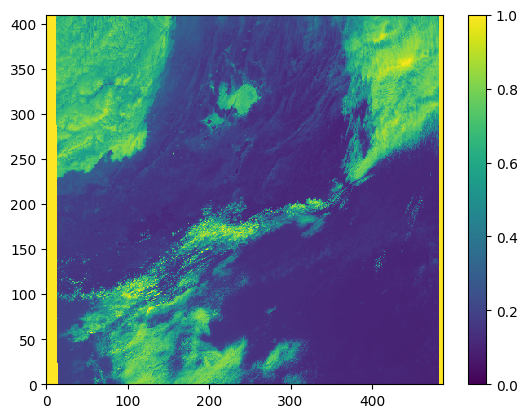

In [ ]:
import matplotlib.pyplot as plt
#Most of the S3 data are not useful to us here
plt.pcolor(reshaped_array[::10,::10,2],vmin=0,vmax=1)
plt.colorbar()

# **Creating masks**
This involves the extraction of three region of interest (roi) from the 3rd chunk image. These 3 roi are then loaded into IRIS for cloud classification, with 3 masks created for each of the roi.

In [ ]:
# Loading the saved chunk 1 to 5 images
image_chunk1 = np.load('/content/drive/MyDrive/GEOL0069/final/output/S3B_OL_1_EFR____20240510T140254_20240510T140554_20240510T154337_0180_093_010_3240_PS2_O_NR_004.SEN3/chunk_1_band_21.npy')
image_chunk2 = np.load('/content/drive/MyDrive/GEOL0069/final/output/S3B_OL_1_EFR____20240510T140254_20240510T140554_20240510T154337_0180_093_010_3240_PS2_O_NR_004.SEN3/chunk_2_band_21.npy')
image_chunk3 = np.load('/content/drive/MyDrive/GEOL0069/final/output/S3B_OL_1_EFR____20240510T140254_20240510T140554_20240510T154337_0180_093_010_3240_PS2_O_NR_004.SEN3/chunk_3_band_21.npy')
image_chunk4 = np.load('/content/drive/MyDrive/GEOL0069/final/output/S3B_OL_1_EFR____20240510T140254_20240510T140554_20240510T154337_0180_093_010_3240_PS2_O_NR_004.SEN3/chunk_4_band_21.npy')
image_chunk5 = np.load('/content/drive/MyDrive/GEOL0069/final/output/S3B_OL_1_EFR____20240510T140254_20240510T140554_20240510T154337_0180_093_010_3240_PS2_O_NR_004.SEN3/chunk_5_band_21.npy')


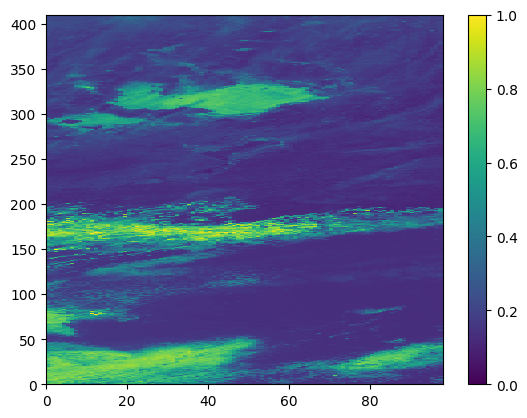

In [ ]:
import matplotlib.pyplot as plt

plt.pcolor(image_chunk3[::10,::10,2],vmin=0,vmax=1)
plt.colorbar()

In [ ]:
# Extracting the region of interest (roi) from the image
x1, y1, x2, y2 = [100,700,300,1000] # roi a
x1b, y1b, x2b, y2b = [100, 400, 300, 700] #roi b
x1c, y1c, x2c, y2c = [100, 1000, 300, 1300] #roi c

roi3a = image_chunk3[y1:y2, x1:x2]
roi3b = image_chunk3[y1b:y2b, x1b:x2b]
roi3c = image_chunk3[y1c:y2c, x1c:x2c]

In [ ]:
path = '/content/drive/MyDrive/GEOL0069/final/'
np.save(path + 'roi3a.npy', roi3a)
np.save(path + 'roi3b.npy', roi3b)
np.save(path + 'roi3c.npy', roi3c)

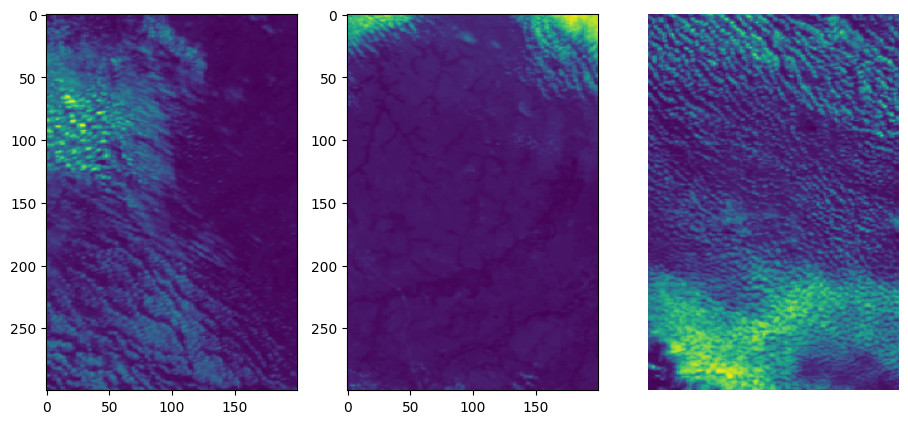

In [ ]:
# Extract channels 1, 2, and 3
channel_3a = roi3a[:,:,6]  # 0-based indexing for the first channel
rgb_image3a = np.stack([channel_3a], axis=-1) # You can add more channels if you want
channel_3b = roi3b[:,:,6]  # 0-based indexing for the first channel
rgb_image3b = np.stack([channel_3b], axis=-1)
channel_3c = roi3c[:,:,6]  # 0-based indexing for the first channel
rgb_image3c = np.stack([channel_3c], axis=-1)

# Plotting the masks area out
plt.figure(figsize=(11, 11))
plt.subplot(1, 3, 1)
plt.imshow(rgb_image3a)
plt.subplot(1, 3, 2)
plt.imshow(rgb_image3b)
plt.subplot(1, 3, 3)
plt.imshow(rgb_image3c)
plt.axis('off')
plt.show()

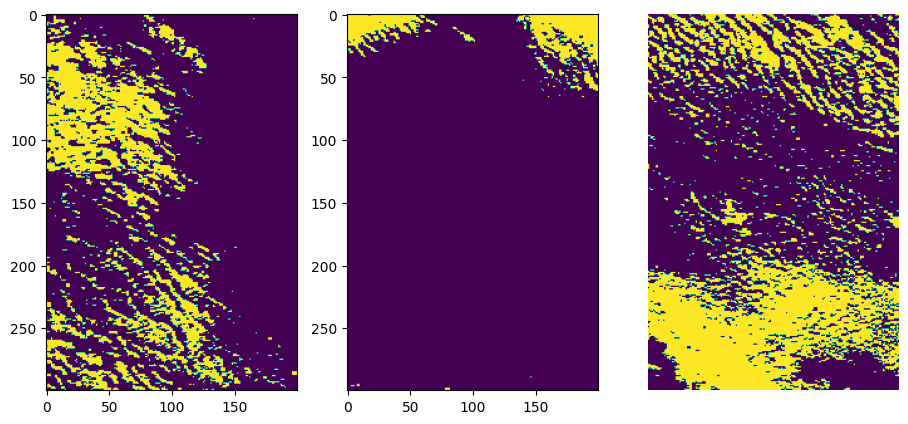

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Now also read in the mask file
maska = cv2.imread('/content/drive/MyDrive/GEOL0069/final/roi3a_mask.png', cv2.IMREAD_UNCHANGED)
maskb = cv2.imread('/content/drive/MyDrive/GEOL0069/final/roi3b_mask.png', cv2.IMREAD_UNCHANGED)
maskc = cv2.imread('/content/drive/MyDrive/GEOL0069/final/roi3c_mask.png', cv2.IMREAD_UNCHANGED)

# Because the mask file is in RGB which has 3 channels, so we should convert it into binary mask as array with only 0 and 1 values
binary_maska = np.where(maska[:,:,0] == 0, 1, 0)
binary_maskb = np.where(maskb[:,:,0] == 0, 1, 0)
binary_maskc = np.where(maskc[:,:,0] == 0, 1, 0)

# Plotting masks out
plt.figure(figsize=(11, 11))
plt.subplot(1, 3, 1)
plt.imshow(binary_maska)
plt.subplot(1, 3, 2)
plt.imshow(binary_maskb)
plt.subplot(1, 3, 3)
plt.imshow(binary_maskc)
plt.axis('off')
plt.show()

In [ ]:
path = '/content/drive/MyDrive/GEOL0069/final/'
np.save(path + 'binary_maska', binary_maska)
np.save(path + 'binary_maskb', binary_maskb)
np.save(path + 'binary_maskc', binary_maskc)

# **Creating training and testing data**
Training and testing data are then created from roi3a, for model creation.

In [ ]:
# for loading the saved roi3 from drive
import numpy as np

path = '/content/drive/MyDrive/GEOL0069/final/'
roi3a = np.load(path + 'roi3a.npy')
roi3b = np.load(path + 'roi3b.npy')
roi3c = np.load(path + 'roi3c.npy')


In [ ]:
# roi is your data with shape (300, 200, 21)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi3a.shape[0] - 1):
    for j in range(1, roi3a.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi3a[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
Patches_array = np.asarray(patches)
# Calculate the number of patches (nx, ny)
nx = roi3a.shape[0] - 2
ny = roi3a.shape[1] - 2

In [ ]:
# Trim the mask to exclude boundary labels
trimmed_maska = binary_maska[1:-1, 1:-1]

# Flatten the trimmed mask to get a 1D array of labels
labels = trimmed_maska.flatten()

print(labels.shape)

(59004,)


In [ ]:
# Initially, we examine the quantity of each class present in the dataset
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Identifying the class with the smaller count to balance the number in each class
num_class = 13127 # Adjust it to the amount you get

{0: 45877, 1: 13127}


In [ ]:
from sklearn.model_selection import train_test_split

# Extract indices of both classes
indices_class_0 = np.where(labels == 0)[0]
indices_class_1 = np.where(labels == 1)[0]

# Randomly sample 9396 indices from class 0
sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

# Combine the sampled indices with indices of class 1
combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

# Extract the corresponding patches and labels
balanced_patches = Patches_array[combined_indices]
balanced_labels = labels[combined_indices]

# Split the balanced dataset into training and testing sets with a 1:9 ratio
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    balanced_patches, balanced_labels, test_size=0.1, random_state=42
)

# Check the balance in y_train_balanced
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))

{0: 11781, 1: 11847}


In [ ]:
path = '/content/drive/MyDrive/GEOL0069/final/'
np.save(path + 'X_train_balanced.npy', X_train_balanced)
np.save(path + 'X_test_balanced.npy', X_test_balanced)
np.save(path + 'y_train_balanced.npy', y_train_balanced)
np.save(path + 'y_test_balanced.npy', y_test_balanced)

# **Creating models**

We create models (Convolutional Neural Network (CNN), Random Forest (RF) and Vision Transformer (ViT)) using mask a (of roi a) from chunk 3 image.

In [ ]:
import os
import numpy as np
path = '/content/drive/MyDrive/GEOL0069/final/'
X_train = np.load(os.path.join(path, 'X_train_balanced.npy'))
X_test = np.load(os.path.join(path, 'X_test_balanced.npy'))
y_train = np.load(os.path.join(path, 'y_train_balanced.npy'))
y_test = np.load(os.path.join(path, 'y_test_balanced.npy'))

## Convolutional Neural Network (CNN)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(3, 3, 21), padding='SAME'))
model.add(layers.MaxPooling2D((2, 2)))
# Add additional convolutional and pooling layers as needed
# ...

# Add dense layers for classification
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # 10 is the number of classes

# Compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
665/665 [==============================] - 4s 4ms/step - loss: 0.3312 - accuracy: 0.8747 - val_loss: 0.1761 - val_accuracy: 0.9365
Epoch 2/10
665/665 [==============================] - 4s 5ms/step - loss: 0.1398 - accuracy: 0.9473 - val_loss: 0.1120 - val_accuracy: 0.9585
Epoch 3/10
665/665 [==============================] - 2s 4ms/step - loss: 0.1176 - accuracy: 0.9526 - val_loss: 0.1401 - val_accuracy: 0.9331
Epoch 4/10
665/665 [==============================] - 2s 3ms/step - loss: 0.1045 - accuracy: 0.9580 - val_loss: 0.0930 - val_accuracy: 0.9628
Epoch 5/10
665/665 [==============================] - 2s 3ms/step - loss: 0.1018 - accuracy: 0.9597 - val_loss: 0.0894 - val_accuracy: 0.9649
Epoch 6/10
665/665 [==============================] - 3s 4ms/step - loss: 0.1036 - accuracy: 0.9574 - val_loss: 0.1166 - val_accuracy: 0.9547
Epoch 7/10
665/665 [==============================] - 4s 6ms/step - loss: 0.0961 - accuracy: 0.9618 - val_loss: 0.0913 - val_accuracy: 0.9649
Epoch 

In [ ]:
model.save('/content/drive/MyDrive/GEOL0069/final/model_CNN')

## Random Forest (RF)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialise the model with n_estimators specifying the number of trees in the forest
clf = RandomForestClassifier(n_estimators=100)

# We need to reshape the data in order to be compatible with Random Forest
X_reshaped = np.reshape(X_train, (X_train.shape[0], -1))
# Fit the model to your training data
clf.fit(X_reshaped, y_train)

RandomForestClassifier()

## Vision Transformer (ViT)

In [ ]:
# Install this additional Tensorflow package for ViT
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Install packages needed
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = more_data(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=30,
        epochs=20,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
num_classes = 2 #Can be changed to multi-classed classification
input_shape = (3, 3, 21) #depends on the size of the image we want

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [ ]:
# Data augmentation
more_data = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="more_data",
)
more_data.layers[0].adapt(X_train)

In [ ]:
# Here vit is your trained model after the training
vit = create_vit_classifier()
history = run_experiment(vit)

Epoch 1/20
709/709 [==============================] - 64s 72ms/step - loss: 0.4373 - accuracy: 0.9475 - top-5-accuracy: 1.0000 - val_loss: 0.0866 - val_accuracy: 0.9704 - val_top-5-accuracy: 1.0000
Epoch 2/20
709/709 [==============================] - 48s 68ms/step - loss: 0.0984 - accuracy: 0.9682 - top-5-accuracy: 1.0000 - val_loss: 0.0788 - val_accuracy: 0.9738 - val_top-5-accuracy: 1.0000
Epoch 3/20
709/709 [==============================] - 48s 68ms/step - loss: 0.0875 - accuracy: 0.9696 - top-5-accuracy: 1.0000 - val_loss: 0.0938 - val_accuracy: 0.9729 - val_top-5-accuracy: 1.0000
Epoch 4/20
709/709 [==============================] - 48s 68ms/step - loss: 0.0827 - accuracy: 0.9723 - top-5-accuracy: 1.0000 - val_loss: 0.0751 - val_accuracy: 0.9767 - val_top-5-accuracy: 1.0000
Epoch 5/20
709/709 [==============================] - 48s 68ms/step - loss: 0.0867 - accuracy: 0.9708 - top-5-accuracy: 1.0000 - val_loss: 0.0855 - val_accuracy: 0.9729 - val_top-5-accuracy: 1.0000
Epoch 6/20

In [ ]:
vit.save('/content/drive/MyDrive/GEOL0069/final/VIT_model')


# **Model Application - roi rollout**

We create the ground truth from the masks, and also the test data (with a (3, 3, 21) patch centered around each pixel extracted and boundary pixels removed), and ensure that they are compatible to each other. Then we apply the models created to the 3 roi.

In [ ]:
# for loading the saved roi3 from drive
import numpy as np

path = '/content/drive/MyDrive/GEOL0069/final/'
roi3a = np.load(path + 'roi3a.npy')
roi3b = np.load(path + 'roi3b.npy')
roi3c = np.load(path + 'roi3c.npy')

# loading the binary masks (ground truth)

path = '/content/drive/MyDrive/GEOL0069/final/'
binary_maska = np.load(path + 'binary_maska.npy')
binary_maskb = np.load(path + 'binary_maskb.npy')
binary_maskc = np.load(path + 'binary_maskc.npy')


In [ ]:
# Trim the mask to exclude boundary labels
trimmed_maska = binary_maska[1:-1, 1:-1]
trimmed_maskb = binary_maskb[1:-1, 1:-1]
trimmed_maskc = binary_maskc[1:-1, 1:-1]

# Flatten the trimmed mask to get a 1D array of labels
# these represents the ground truth for the 3 roi
true_a = trimmed_maska.flatten()
true_b = trimmed_maskb.flatten()
true_c = trimmed_maskc.flatten()

import os
save_path = '/content/drive/MyDrive/GEOL0069/final/'
np.save(os.path.join(save_path, 'true_a'), true_a)
np.save(os.path.join(save_path, 'true_b'), true_b)
np.save(os.path.join(save_path, 'true_c'), true_c)

In [ ]:
# CNN
# roi is your data with shape (300, 200, 21)
patches_a = []
patches_b = []
patches_c = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi3a.shape[0] - 1):
    for j in range(1, roi3a.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi3a[i-1:i+2, j-1:j+2, :]
        patches_a.append(patch)

for i in range(1, roi3b.shape[0] - 1):
    for j in range(1, roi3b.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi3b[i-1:i+2, j-1:j+2, :]
        patches_b.append(patch)

for i in range(1, roi3c.shape[0] - 1):
    for j in range(1, roi3c.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi3c[i-1:i+2, j-1:j+2, :]
        patches_c.append(patch)

# Convert the list of patches to a numpy array
x_test_a = np.array(patches_a)
Patches_array_a = np.asarray(patches_a)
x_test_b = np.array(patches_b)
Patches_array_b = np.asarray(patches_b)
x_test_c = np.array(patches_c)
Patches_array_c = np.asarray(patches_c)

# Calculate the number of patches (nx, ny)
nx = roi3a.shape[0] - 2
ny = roi3a.shape[1] - 2


## CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
model_CNN = tf.keras.models.load_model('/content/drive/MyDrive/GEOL0069/final/model_CNN')

In [ ]:
y_preda = model_CNN.predict(x_test_a, batch_size = 250)
y_predb = model_CNN.predict(x_test_b, batch_size = 250)
y_predc = model_CNN.predict(x_test_c, batch_size = 250)
y_pred1 = np.argmax(y_preda,axis = 1)
y_pred2 = np.argmax(y_predb,axis = 1)
y_pred3 = np.argmax(y_predc,axis = 1)
# reshape for map display
map1 = y_pred1.reshape(nx, ny)
map2 = y_pred2.reshape(nx, ny)
map3 = y_pred3.reshape(nx, ny)

237/237 [==============================] - 0s 2ms/step


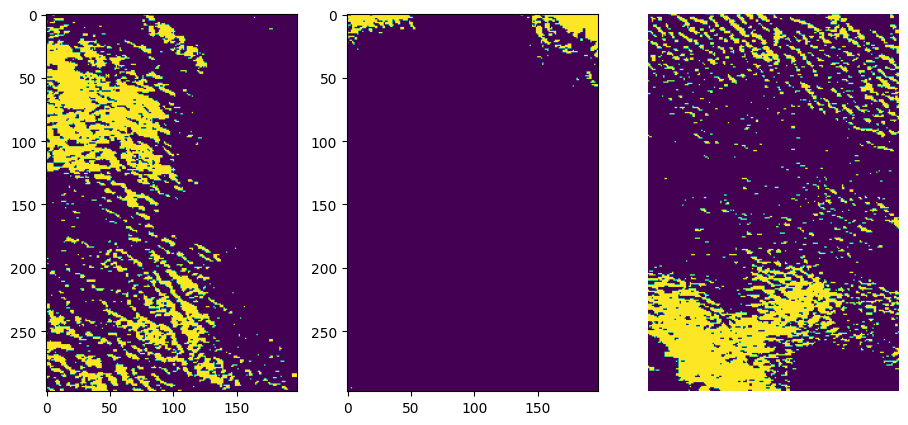

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 11))
plt.subplot(1, 3, 1)
plt.imshow(map1)
plt.subplot(1, 3, 2)
plt.imshow(map2)
plt.subplot(1, 3, 3)
plt.imshow(map3)
plt.axis('off')
plt.show()

In [ ]:
import os
save_path = '/content/drive/MyDrive/GEOL0069/final/'
np.save(os.path.join(save_path, 'CNN_chunk3_a'), map1)
np.save(os.path.join(save_path, 'CNN_chunk3_b'), map2)
np.save(os.path.join(save_path, 'CNN_chunk3_c'), map3)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     45877
           1       0.94      0.91      0.92     13127

    accuracy                           0.97     59004
   macro avg       0.96      0.95      0.95     59004
weighted avg       0.97      0.97      0.97     59004

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     56085
           1       1.00      0.49      0.66      2919

    accuracy                           0.97     59004
   macro avg       0.99      0.75      0.82     59004
weighted avg       0.98      0.97      0.97     59004

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     37426
           1       0.99      0.57      0.72     21578

    accuracy                           0.84     59004
   macro avg       0.89      0.78      0.80     59004
we

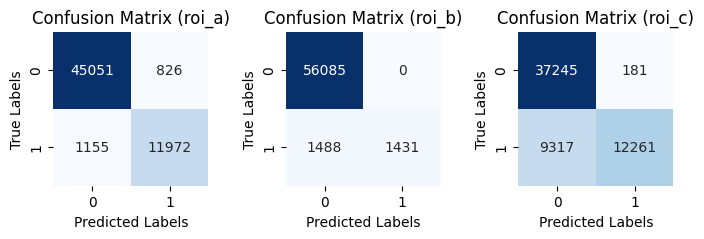

Accuracy: 0.97
Accuracy: 0.97
Accuracy: 0.84


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Compute confusion matrix
cm_a = confusion_matrix(true_a, y_pred1)
cm_b = confusion_matrix(true_b, y_pred2)
cm_c = confusion_matrix(true_c, y_pred3)

# Calculate accuracy
accuracy_a = accuracy_score(true_a, y_pred1)
accuracy_b = accuracy_score(true_b, y_pred2)
accuracy_c = accuracy_score(true_c, y_pred3)

# Display classification report
report_a = classification_report(true_a, y_pred1)
report_b = classification_report(true_b, y_pred2)
report_c = classification_report(true_c, y_pred3)
print("Classification Report:\n", report_a)
print("Classification Report:\n", report_b)
print("Classification Report:\n", report_c)

# Plot confusion matrix
plt.figure(figsize=(8, 2))
plt.subplot(1, 3, 1)
sns.heatmap(cm_a, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (roi_a)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.subplot(1, 3, 2)
sns.heatmap(cm_b, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (roi_b)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.subplot(1, 3, 3)
sns.heatmap(cm_c, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.title("Confusion Matrix (roi_c)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display accuracy
print(f"Accuracy: {accuracy_a:.2f}")
print(f"Accuracy: {accuracy_b:.2f}")
print(f"Accuracy: {accuracy_c:.2f}")

## RF

In [ ]:
# re-creating the RF model as it is not saved

from sklearn.ensemble import RandomForestClassifier

# Initialise the model with n_estimators specifying the number of trees in the forest
clf = RandomForestClassifier(n_estimators=100)

# We need to reshape the data in order to be compatible with Random Forest
X_reshaped = np.reshape(X_train, (X_train.shape[0], -1))
# Fit the model to your training data
clf.fit(X_reshaped, y_train)

In [ ]:
# reshape the testing data
x_test_a_RF = x_test_a.reshape(-1, 3*3*21)
x_test_b_RF = x_test_b.reshape(-1, 3*3*21)
x_test_c_RF = x_test_c.reshape(-1, 3*3*21)

# Fit the model to your data
y_clfpred_a = clf.predict(x_test_a_RF)
y_clfpred_b = clf.predict(x_test_b_RF)
y_clfpred_c = clf.predict(x_test_c_RF)

# reshape for map display
map4 = y_clfpred_a.reshape(nx, ny)
map5 = y_clfpred_b.reshape(nx, ny)
map6 = y_clfpred_c.reshape(nx, ny)

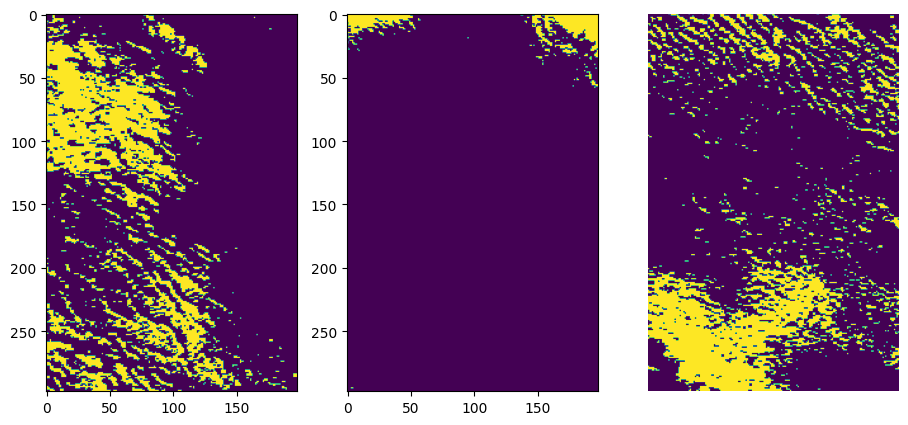

In [ ]:
plt.figure(figsize=(11, 11))
plt.subplot(1, 3, 1)
plt.imshow(map4)
plt.subplot(1, 3, 2)
plt.imshow(map5)
plt.subplot(1, 3, 3)
plt.imshow(map6)
plt.axis('off')
plt.show()

In [ ]:
import os
save_path = '/content/drive/MyDrive/GEOL0069/final/'
np.save(os.path.join(save_path, 'RF_chunk3_a'), map4)
np.save(os.path.join(save_path, 'RF_chunk3_b'), map5)
np.save(os.path.join(save_path, 'RF_chunk3_c'), map6)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     45877
           1       0.97      1.00      0.98     13127

    accuracy                           0.99     59004
   macro avg       0.98      0.99      0.99     59004
weighted avg       0.99      0.99      0.99     59004

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     56085
           1       1.00      0.54      0.70      2919

    accuracy                           0.98     59004
   macro avg       0.99      0.77      0.85     59004
weighted avg       0.98      0.98      0.97     59004

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89     37426
           1       0.97      0.59      0.73     21578

    accuracy                           0.84     59004
   macro avg       0.89      0.79      0.81     59004
we

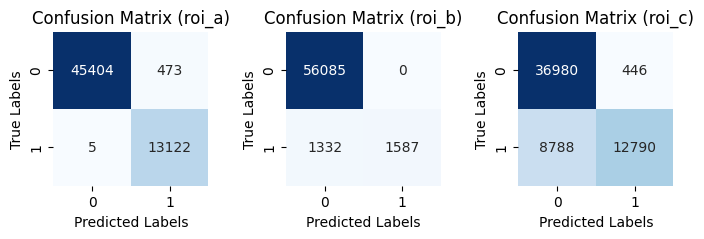

Accuracy: 0.99
Accuracy: 0.98
Accuracy: 0.84


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Compute confusion matrix
cm_a = confusion_matrix(true_a, y_clfpred_a)
cm_b = confusion_matrix(true_b, y_clfpred_b)
cm_c = confusion_matrix(true_c, y_clfpred_c)

# Calculate accuracy
accuracy_a = accuracy_score(true_a, y_clfpred_a)
accuracy_b = accuracy_score(true_b, y_clfpred_b)
accuracy_c = accuracy_score(true_c, y_clfpred_c)

# Display classification report
report_a = classification_report(true_a, y_clfpred_a)
report_b = classification_report(true_b, y_clfpred_b)
report_c = classification_report(true_c, y_clfpred_c)
print("Classification Report:\n", report_a)
print("Classification Report:\n", report_b)
print("Classification Report:\n", report_c)

# Plot confusion matrix
plt.figure(figsize=(8, 2))
plt.subplot(1, 3, 1)
sns.heatmap(cm_a, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (roi_a)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.subplot(1, 3, 2)
sns.heatmap(cm_b, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (roi_b)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.subplot(1, 3, 3)
sns.heatmap(cm_c, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.title("Confusion Matrix (roi_c)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display accuracy
print(f"Accuracy: {accuracy_a:.2f}")
print(f"Accuracy: {accuracy_b:.2f}")
print(f"Accuracy: {accuracy_c:.2f}")

## ViT

In [ ]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow_addons.optimizers import AdamW  # Import the custom optimizer
model_ViT = tf.keras.models.load_model('/content/drive/MyDrive/GEOL0069/final/VIT_model')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# performing prediction with the ViT model
y_vitpred_a = model_ViT.predict(x_test_a)
y_vitpred_b = model_ViT.predict(x_test_b)
y_vitpred_c = model_ViT.predict(x_test_c)

y_vit_a = np.argmax(y_vitpred_a,axis = 1)
y_vit_b = np.argmax(y_vitpred_b,axis = 1)
y_vit_c = np.argmax(y_vitpred_c,axis = 1)

# reshape for map display
map7 = y_vit_a.reshape(nx, ny)
map8 = y_vit_b.reshape(nx, ny)
map9 = y_vit_c.reshape(nx, ny)

1844/1844 [==============================] - 44s 24ms/step


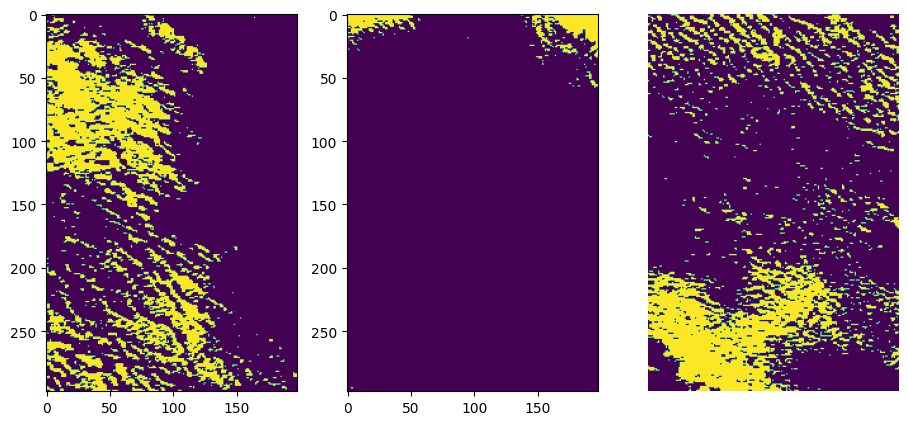

In [ ]:
plt.figure(figsize=(11, 11))
plt.subplot(1, 3, 1)
plt.imshow(map7)
plt.subplot(1, 3, 2)
plt.imshow(map8)
plt.subplot(1, 3, 3)
plt.imshow(map9)
plt.axis('off')
plt.show()

In [ ]:
import os
save_path = '/content/drive/MyDrive/GEOL0069/final/'
np.save(os.path.join(save_path, 'ViT_chunk3_a'), map7)
np.save(os.path.join(save_path, 'ViT_chunk3_b'), map8)
np.save(os.path.join(save_path, 'ViT_chunk3_c'), map9)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     45877
           1       0.92      0.99      0.95     13127

    accuracy                           0.98     59004
   macro avg       0.96      0.98      0.97     59004
weighted avg       0.98      0.98      0.98     59004

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     56085
           1       1.00      0.54      0.70      2919

    accuracy                           0.98     59004
   macro avg       0.99      0.77      0.85     59004
weighted avg       0.98      0.98      0.97     59004

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89     37426
           1       0.96      0.61      0.74     21578

    accuracy                           0.85     59004
   macro avg       0.89      0.80      0.82     59004
we

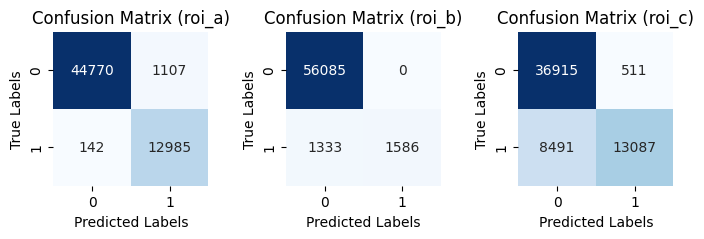

Accuracy: 0.98
Accuracy: 0.98
Accuracy: 0.85


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Compute confusion matrix
cm_a = confusion_matrix(true_a, y_vit_a)
cm_b = confusion_matrix(true_b, y_vit_b)
cm_c = confusion_matrix(true_c, y_vit_c)

# Calculate accuracy
accuracy_a = accuracy_score(true_a, y_vit_a)
accuracy_b = accuracy_score(true_b, y_vit_b)
accuracy_c = accuracy_score(true_c, y_vit_c)

# Display classification report
report_a = classification_report(true_a, y_vit_a)
report_b = classification_report(true_b, y_vit_b)
report_c = classification_report(true_c, y_vit_c)
print("Classification Report:\n", report_a)
print("Classification Report:\n", report_b)
print("Classification Report:\n", report_c)

# Plot confusion matrix
plt.figure(figsize=(8, 2))
plt.subplot(1, 3, 1)
sns.heatmap(cm_a, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (roi_a)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.subplot(1, 3, 2)
sns.heatmap(cm_b, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (roi_b)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.subplot(1, 3, 3)
sns.heatmap(cm_c, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.title("Confusion Matrix (roi_c)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display accuracy
print(f"Accuracy: {accuracy_a:.2f}")
print(f"Accuracy: {accuracy_b:.2f}")
print(f"Accuracy: {accuracy_c:.2f}")